# Load in model

In [19]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from datasets import Dataset, load_dataset
from tqdm.auto import tqdm
from functools import partial
from einops import rearrange
from huggingface_hub import hf_hub_download
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification


# Download the model
device = "cuda:0"
model_name="EleutherAI/Pythia-70M-deduped"
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load in Sparse AE's

In [20]:
from autoencoders import *
# ae_model_id = ["jbrinkma/Pythia-70M-chess_sp51_r4_gpt_neox.layers.1", "jbrinkma/Pythia-70M-chess_sp51_r4_gpt_neox.layers.2.mlp"]
model_id = "jbrinkma/Pythia-70M-deduped-SAEs"
filename = ["Pythia-70M-deduped-1.pt", "Pythia-70M-deduped-mlp-2.pt"]
autoencoders = []
for filen in filename:
    ae_download_location = hf_hub_download(repo_id=model_id, filename=filen)
    autoencoder = torch.load(ae_download_location)
    autoencoder.to_device(device)
    autoencoders.append(autoencoder)
cache_names = ["gpt_neox.layers.1", "gpt_neox.layers.2.mlp"]

# Load training data

In [21]:
max_seq_length=80 # max length of per data point
from datasets import load_dataset
# dataset_name = "NeelNanda/pile-10k"
dataset_name = "stas/openwebtext-10k"
dataset = load_dataset(dataset_name, split="train").map(
    lambda x: tokenizer(x['text']),
    batched=True
).filter(
    lambda x: len(x['input_ids']) > max_seq_length
).map(
    lambda x: {'input_ids': x['input_ids'][:max_seq_length]}
)

/root/logan/lib/python3.10/site-packages/datasets/download/download_manager.py:527: FutureWarning: 'num_proc' was deprecated in version 2.6.2 and will be removed in 3.0.0. Pass `DownloadConfig(num_proc=<num_proc>)` to the initializer instead.
  warnings.warn(
Extracting data files: 100%|██████████| 1/1 [00:02<00:00,  2.70s/it]


Dataset openwebtext-10k downloaded and prepared to /root/.cache/huggingface/datasets/stas___openwebtext-10k/plain_text/1.0.0/3a8df094c671b4cb63ed0b41f40fb3bd855e9ce2e3765e5df50abcdfb5ec144b. Subsequent calls will reuse this data.


## Grab Intermediate Layer Activations

In [22]:
from baukit import TraceDict
# with TraceDict(model, cache_names) as ret:

num_features, d_model = autoencoder.encoder.shape
datapoints = dataset.num_rows
batch_size = 32
with torch.no_grad(), dataset.formatted_as("pt"):
    dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
    for i, batch in enumerate(tqdm(dl)):
        batch = batch.to(device)
        # Get LLM intermediate activations
        with TraceDict(model, cache_names) as ret:
            _ = model(batch)
        # Get SAE intermediate codes
        for ae_ind, cache_name in enumerate(cache_names):
            autoencoder = autoencoders[ae_ind]
            internal_activations = ret[cache_name].output
            # check if instance tuple ie a layer output
            if(isinstance(internal_activations, tuple)):
                internal_activations = internal_activations[0]

            batched_neuron_activations = rearrange(internal_activations, "b s n -> (b s) n" )
            batched_dictionary_activations = autoencoder.encode(batched_neuron_activations)

  0%|          | 0/313 [00:00<?, ?it/s]

100%|██████████| 313/313 [00:19<00:00, 16.07it/s]


In [23]:
# Boiler plate ML code
# D2 = ReLU(W@d1 + b)
# Input = Residual Stream
# Output = MLP_out
from torch import nn
class sparse_nonlinear(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.linear = nn.Linear(input_size, input_size)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        return x
    
Sparse_nonlinear = sparse_nonlinear(num_features)
Sparse_nonlinear.to(device)
# Optimizer
from torch.optim import Adam
optimizer = Adam(Sparse_nonlinear.parameters(), lr=1e-3)

# Loss
# 1. MSE 
# 2. sparsity on W (linear) (L1)
mse = nn.MSELoss() # TODO: jannik
l1_alpha = 1e-3

from baukit import TraceDict
num_features, d_model = autoencoder.encoder.shape
datapoints = dataset.num_rows
batch_size = 32
dictionary_activations = [0, 0]
with dataset.formatted_as("pt"):
    dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
    for i, batch in enumerate(tqdm(dl)):
        with torch.no_grad():
            batch = batch.to(device)
            # Get LLM intermediate activations
            with TraceDict(model, cache_names) as ret:
                _ = model(batch)
            # Get SAE intermediate codes
            for ae_ind, cache_name in enumerate(cache_names):
                autoencoder = autoencoders[ae_ind]
                internal_activations = ret[cache_name].output
                # check if instance tuple ie a layer output
                if(isinstance(internal_activations, tuple)):
                    internal_activations = internal_activations[0]

                batched_neuron_activations = rearrange(internal_activations, "b s n -> (b s) n" )
                dictionary_activations[ae_ind] = autoencoder.encode(batched_neuron_activations)
        # Run through sparse_weight_matrix
        x_hat = Sparse_nonlinear(dictionary_activations[0])
        # Get loss
        loss = mse(x_hat, dictionary_activations[1])
        l1_loss = torch.norm(Sparse_nonlinear.linear.weight, dim=1, p=1).mean()
        loss += l1_alpha*l1_loss
        # Backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if(i%100==0):
            print(f"MSE Loss: {loss.item()} | L1 Loss: {l1_loss.item()}")

  0%|          | 0/313 [00:00<?, ?it/s]

  1%|▏         | 4/313 [00:00<00:22, 13.71it/s]

MSE Loss: 0.07358858734369278 | L1 Loss: 27.699935913085938


 33%|███▎      | 104/313 [00:08<00:17, 11.91it/s]

MSE Loss: 0.0358312763273716 | L1 Loss: 0.5057389736175537


 65%|██████▌   | 204/313 [00:17<00:09, 11.86it/s]

MSE Loss: 0.031030012294650078 | L1 Loss: 0.5701619386672974


 97%|█████████▋| 304/313 [00:25<00:00, 11.86it/s]

MSE Loss: 0.02557392045855522 | L1 Loss: 0.6439201235771179


100%|██████████| 313/313 [00:26<00:00, 11.90it/s]


In [7]:
# f2 = ReLU(w*f1 + b)
'''
d1= [f_0, f_1]

w = [w00, w01]
    [w10, w11]

f2 = [f_0*w00 + f_1*w10, f_0*w01 +f_1*w11]
'''

'\nd1= [f_0, f_1]\n\nw = [w00, w01]\n    [w10, w11]\n\nf2 = [f_0*w00 + f_1*w10, f_0*w01 +f_1*w11]\n'

In [8]:
squished = Sparse_nonlinear.linear.weight.detach().flatten()
top_val, top_ind = torch.topk(squished, 10)
row_ind = top_ind//num_features
col_ind = top_ind%num_features
# Row is output feature index
# Col is input feature index
top_val, row_ind, col_ind

(tensor([0.3094, 0.3066, 0.3037, 0.2994, 0.2993, 0.2983, 0.2954, 0.2943, 0.2936,
         0.2929], device='cuda:0'),
 tensor([2390, 2863, 2863, 1582, 1224, 2390, 1224, 2863, 2863, 1224],
        device='cuda:0'),
 tensor([3028, 2917, 1904, 3028,  247, 1404, 3028,   67,  247, 1904],
        device='cuda:0'))

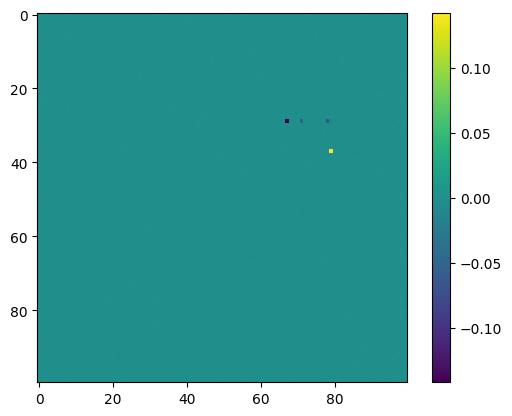

In [9]:
# Plot weight matrix as image
import matplotlib.pyplot as plt
plt.imshow(Sparse_nonlinear.linear.weight[:100,:100].detach().cpu())
plt.colorbar()
plt.show()

In [10]:
indices = (Sparse_nonlinear.linear.weight > 0.001).nonzero()
indices, Sparse_nonlinear.linear.weight[indices[:,0], indices[:,1]]

(tensor([[   1, 2191],
         [   1, 3014],
         [  11,  596],
         ...,
         [3065, 2497],
         [3066,  658],
         [3066,  668]], device='cuda:0'),
 tensor([0.1169, 0.0689, 0.1657,  ..., 0.0747, 0.0159, 0.1725], device='cuda:0',
        grad_fn=<IndexBackward0>))

In [11]:
indices[:6]

tensor([[   1, 2191],
        [   1, 3014],
        [  11,  596],
        [  11, 1184],
        [  11, 1495],
        [  11, 1864]], device='cuda:0')

In [12]:
indices[20:30]

tensor([[  16,  606],
        [  16,  785],
        [  16,  792],
        [  16,  963],
        [  16, 1124],
        [  16, 1521],
        [  16, 1527],
        [  16, 1795],
        [  16, 1800],
        [  16, 1903]], device='cuda:0')

In [13]:
indices[200:210]

tensor([[  37, 1316],
        [  37, 1325],
        [  37, 1326],
        [  37, 1478],
        [  37, 1548],
        [  37, 1885],
        [  47, 1176],
        [  47, 2070],
        [  47, 2533],
        [  79,  595]], device='cuda:0')

In [14]:
f_ind = 1899
Sparse_nonlinear.linear.weight[:, f_ind].topk(5).values, Sparse_nonlinear.linear.weight[f_ind, :].topk(5).values

(tensor([0.0828, 0.0023, 0.0022, 0.0014, 0.0009], device='cuda:0',
        grad_fn=<TopkBackward0>),
 tensor([0.1980, 0.1734, 0.1371, 0.1282, 0.1280], device='cuda:0',
        grad_fn=<TopkBackward0>))

In [18]:
features = [11, 29, 203]
import matplotlib.pyplot as plt
for x in features:
    val = Sparse_nonlinear.linear.weight[x]
#     plt.hist(val.detach().cpu().numpy(), bins=50, label=f"Feature {x}")
    mean = val.mean()
    std = val.std()
    min = val.min()
    max = val.max()
    print(f"Feature {x}: mean: {mean}, std: {std}, min: {min}, max: {max}")
# plt.legend()
plt.show()

Feature 11: mean: 0.0001571535540279001, std: 0.00546741159632802, min: -0.10035543143749237, max: 0.16572602093219757
Feature 29: mean: -0.0004656702221836895, std: 0.011058892123401165, min: -0.2426990568637848, max: 0.15703199803829193
Feature 203: mean: 0.0017885728739202023, std: 0.03143875673413277, min: -0.22366595268249512, max: 0.2349885255098343


In [39]:
f_ind = 9
print("Dead Feature")
print(f"column: {Sparse_nonlinear.linear.weight[:, f_ind].topk(5).values}")
print(f"Row: { Sparse_nonlinear.linear.weight[f_ind, :].topk(5).values}")
    

Dead Feature
column: tensor([0.1078, 0.0246, 0.0006, 0.0006, 0.0006], device='cuda:0',
       grad_fn=<TopkBackward0>)
Row: tensor([0.0006, 0.0006, 0.0006, 0.0006, 0.0006], device='cuda:0',
       grad_fn=<TopkBackward0>)


In [31]:
# dictionary_activations[:100000].count_nonzero(0).count_nonzero(0)
dictionary_activations[:10000].count_nonzero(0).topk(10, largest=False), dictionary_activations[:10000].count_nonzero(0).topk(10, largest=True)

(torch.return_types.topk(
 values=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 indices=tensor([ 8,  9,  4,  7,  5,  3,  0, 10,  2,  6])),
 torch.return_types.topk(
 values=tensor([4094, 3426, 3297, 2861, 2722, 2140, 1370, 1369, 1354, 1084]),
 indices=tensor([1899,  203,  905,  260, 1773, 1191, 2863, 1224, 2390,  628])))

In [17]:
dictionary_activations.shape

torch.Size([297480, 3072])

In [9]:
from alpha_utils_interp import *
import os
# make features/ dir if not exist
save_path = "features/"
if not os.path.exists(save_path):
    os.makedirs(save_path)
num_feature_datapoints = 10
dictionary_activations, tokens_for_each_datapoint = get_dictionary_activations(model, dataset, cache_name, max_seq_length, autoencoder, batch_size=32)

# features = [1,2,3,4,5,6,7,8,9,10]
# features = [5,6]
# features = None
num_features = 30
feature = 0
input_setting = "input_only"
for _ in range(num_features):
    # Check if feature is dead (<10 activations)
    dead_threshold = 10
    # if(dictionary_activations[:, current_feature].count_nonzero() < dead_threshold):
    while(dictionary_activations[:, feature].count_nonzero() < dead_threshold):
        print(f"Feature {feature} is dead")
        feature += 1
    uniform_indices = get_feature_indices(feature, dictionary_activations, k=num_feature_datapoints, setting="uniform")
    text_list, full_text, token_list, full_token_list, partial_activations, full_activations = get_feature_datapoints(uniform_indices, dictionary_activations[:, feature], tokenizer, max_seq_length, dataset)
    # get_token_statistics(feature, dictionary_activations[:, feature], dataset, tokenizer, max_seq_length, tokens_for_each_datapoint, save_location = save_path, num_unique_tokens=10)
    if(input_setting == "input_only"):
        # Calculate logit diffs on this feature for the full_token_list
        logit_diffs = ablate_feature_direction(model, full_token_list, cache_name, max_seq_length, autoencoder, feature = feature, batch_size=32, setting="sentences", model_type=model_type)
        # save_token_display(full_token_list, full_activations, tokenizer, path =f"{save_path}uniform_{feature}.png", logit_diffs = logit_diffs, model_type=model_type)
        save_token_display(full_token_list, full_activations, tokenizer, path =f"{save_path}uniform_{feature}.png", logit_diffs = logit_diffs, model_type=model_type, show=True)
        all_changed_activations = ablate_context_one_token_at_a_time(model, token_list, cache_name, autoencoder, feature, max_ablation_length=30)
        save_token_display(token_list, all_changed_activations, tokenizer, path =f"{save_path}ablate_context_{feature}.png", model_type=model_type, show=True)
    else:
        logit_diffs = ablate_feature_direction(model, dataset, cache_name, max_seq_length, autoencoder, feature = feature, batch_size=32, setting="dataset")
        _, _, _, full_token_list_ablated, _, full_activations_ablated = get_feature_datapoints(uniform_indices, logit_diffs, tokenizer, max_seq_length, dataset)
        get_token_statistics(feature, logit_diffs, dataset, tokenizer, max_seq_length, tokens_for_each_datapoint, save_location = save_path, setting="output", num_unique_tokens=10)
        save_token_display(full_token_list_ablated, full_activations, tokenizer, path =f"{save_path}uniform_{feature}.png", logit_diffs = full_activations_ablated)
    # if(ablate_context ==True):
    #     all_changed_activations = ablate_context_one_token_at_a_time(model, dataset, cache_name, autoencoder, feature, max_ablation_length=20)
    #     save_token_display(token_list, all_changed_activations, tokenizer, path =f"{save_path}ablate_context_{feature}.png", model_type=model_type, show=True)
    # combine_images(feature, setting=input_setting, ablate_context=ablate_context)
    feature += 1

100%|██████████| 310/310 [00:10<00:00, 29.77it/s]
/root/sparse_coding/alpha_utils_interp.py:349: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at ../aten/src/ATen/native/BucketizationUtils.h:33.)
  bins = torch.bucketize(best_feature_activations, bin_boundaries)


Feature 0 is dead


NameError: name 'model_type' is not defined

In [ ]:
Sparse_nonlinear.linear.weight[:, x].topk(10)

torch.return_types.topk(
values=tensor([0.0016, 0.0008, 0.0007, 0.0007, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006,
        0.0005], device='cuda:0', grad_fn=<TopkBackward0>),
indices=tensor([1899, 2168, 2598, 1191, 2841, 1595,  601, 2818,  905,  983],
       device='cuda:0'))

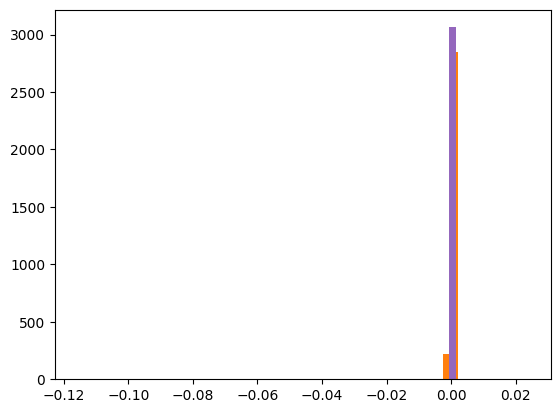

In [50]:
# hist the first 5 neurons
import matplotlib.pyplot as plt
for x in range(5):
    val = Sparse_nonlinear.linear.weight[:, x]
    plt.hist(val.detach().cpu().numpy(), bins=50)
plt.show()

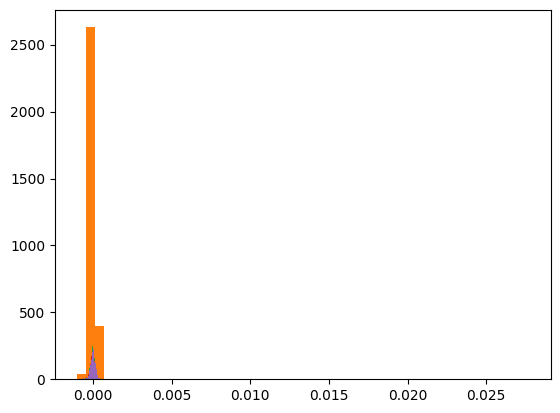

In [51]:
# hist the first 5 neurons
import matplotlib.pyplot as plt
for x in range(5):
    val = Sparse_nonlinear.linear.weight[x, :]
    plt.hist(val.detach().cpu().numpy(), bins=50)
plt.show()

In [37]:
list(Sparse_nonlinear.parameters())

[Parameter containing:
 tensor([[ 0.0124, -0.0044, -0.0002,  ..., -0.0062, -0.0021,  0.0138],
         [ 0.0145, -0.0066, -0.0114,  ...,  0.0170,  0.0121, -0.0112],
         [-0.0014,  0.0121, -0.0046,  ..., -0.0161,  0.0043, -0.0040],
         ...,
         [-0.0075,  0.0023,  0.0118,  ..., -0.0031, -0.0092, -0.0004],
         [-0.0063,  0.0080,  0.0002,  ..., -0.0180, -0.0156,  0.0083],
         [ 0.0041,  0.0157, -0.0164,  ...,  0.0036,  0.0057, -0.0050]],
        device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([ 0.0098, -0.0107,  0.0123,  ...,  0.0170,  0.0130,  0.0111],
        device='cuda:0', requires_grad=True)]

In [ ]:
Sparse_nonlinear.linear.weight.shape

In [ ]:
dictionary_activations[0].count_nonzero(dim=-1).float().mean()